In [1]:
import pandas as pd
cocacola = pd.read_csv("CocaCola_Sales_Rawdata.csv")
Quarter =['Q1','Q2','Q3','Q4'] 
import numpy as np
n = cocacola["Quarter"][0]
n[0:3]
cocacola['quarter']= 0

In [2]:
for i in range(42):
    n = cocacola["Quarter"][i]
    cocacola['quarter'][i]= n[0:3]

<ipython-input-2-9f7e89495720>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cocacola['quarter'][i]= n[0:3]
C:\Users\anbuc\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [3]:
quarter_dummies=pd.DataFrame(pd.get_dummies(cocacola['quarter']))

In [4]:
coca = pd.concat([cocacola,quarter_dummies],axis = 1)

In [5]:
coca["t"] = np.arange(1,43)

coca["t_squared"] = coca["t"]*coca["t"]
coca.columns

Index(['Quarter', 'Year', 'Sales', 'quarter', 'Q1', 'Q2', 'Q3', 'Q4', 't',
       't_squared'],
      dtype='object')

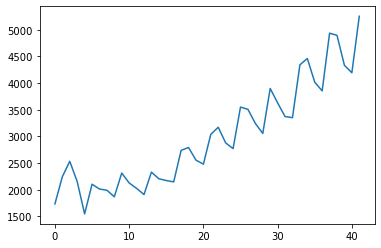

In [6]:
coca['log_Sales'] = np.log(coca["Sales"])
coca.rename(columns={"Sales ": 'Sales'}, inplace=True)
coca.Sales.plot()
Train = coca.head(30)
Test = coca.tail(12)

<AxesSubplot:xlabel='Quarter', ylabel='Year'>

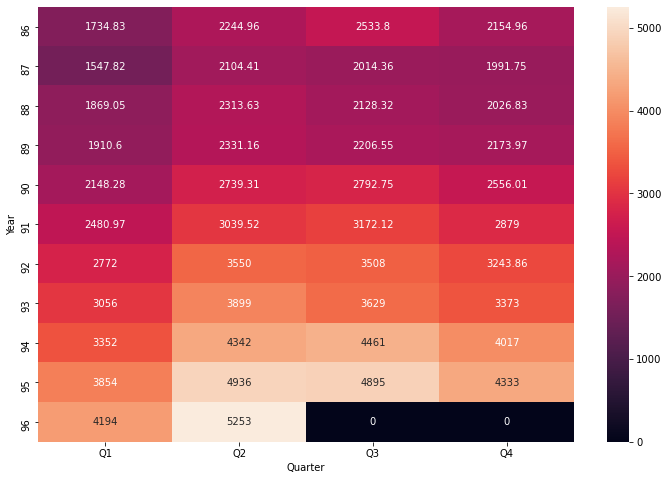

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,8))
heatmap_y_Quarter = pd.pivot_table(data=cocacola,values="Sales",index="Year",columns="Quarter",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_Quarter,annot=True,fmt="g") 

In [8]:
####################### L I N E A R ##########################

In [9]:
import statsmodels.formula.api as smf 

linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
rmse_linear

714.0144483818336

In [10]:
##################### Exponential ##############################

Exp = smf.ols('log_Sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

552.2821039688192

In [11]:
#################### Quadratic ###############################

Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

646.2715428655368

In [12]:
################### Additive seasonality ########################

add_sea = smf.ols('Sales~Q1+Q2+Q3',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Q1','Q2','Q3']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1778.0065467724012

In [13]:
################## Additive Seasonality Quadratic ############################

add_sea_Quad = smf.ols('Sales~t+t_squared+Q1+Q2+Q3',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Q1','Q2','Q3','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad 


586.0533068426641

In [14]:
##################Multiplicative Additive Seasonality ###########

Mult_add_sea = smf.ols('log_Sales~t+Q1+Q2+Q3',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mult_add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

410.24970605323097

In [15]:
################## Multiplicative Seasonality ##################

Mul_sea = smf.ols('log_Sales~Q1+Q2+Q3',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1828.9238911891944

In [16]:
################## Testing #######################################

data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
data

{'MODEL': 0          rmse_linear
 1             rmse_Exp
 2            rmse_Quad
 3         rmse_add_sea
 4    rmse_add_sea_quad
 5        rmse_Mult_sea
 6    rmse_Mult_add_sea
 dtype: object,
 'RMSE_Values': 0     714.014448
 1     552.282104
 2     646.271543
 3    1778.006547
 4     586.053307
 5    1828.923891
 6     410.249706
 dtype: float64}

In [17]:
table_rmse=pd.DataFrame(data)
table_rmse

,MODEL,RMSE_Values
0,rmse_linear,714.014448
1,rmse_Exp,552.282104
2,rmse_Quad,646.271543
3,rmse_add_sea,1778.006547
4,rmse_add_sea_quad,586.053307
5,rmse_Mult_sea,1828.923891
6,rmse_Mult_add_sea,410.249706


# Predict for new time period

In [24]:
#final model with least rmse value
coca_pred = pd.read_csv("coca_pred1.csv")

In [30]:
coca_pred["t"] = np.arange(1,7)

In [27]:
final= smf.ols('log_Sales~t+Q1+Q2+Q3',data=coca).fit()

In [28]:
pred_new  = pd.Series(Mult_add_sea.predict(coca_pred))
pred_new

0    7.552432
1    7.480890
2    7.409373
3    7.648671
4    7.638167
5    7.566625
dtype: float64

In [29]:
coca_pred["forecasted_Sales"] = pd.Series(pred_new)

In [31]:
coca_pred

,Quarter,Year,Q1,Q2,Q3,Q4,t,forecasted_Sales
0,Q3,96,0,0,1,0,1,7.552432
1,Q4,96,0,0,0,1,2,7.480890
2,Q1,97,1,0,0,0,3,7.409373
3,Q2,97,0,1,0,0,4,7.648671
4,Q3,97,0,0,1,0,5,7.638167
5,Q4,97,0,0,0,1,6,7.566625
